## Анализ временных рядов


В данной задаче вы будете работать с данными температуре воздуха. Таблица содержит данные погоды примерно за 5 лет для городов США, Канады и Израиля. 
Файл `temperature.csv` содержит температуру в градусах Кельвина.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

Загрузите таблицу. Обратиет внимание на параметр `parse_dates`, он используется для приведения столбца с датами к правильному типу данных.

In [2]:
df = pd.read_csv('temperature.csv', parse_dates=['datetime'])

Установим дату как индекс

In [3]:
df = df.set_index('datetime')
df.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,284.610000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,284.607306,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,284.599918,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,284.592530,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


Посмотрим, как выглядят наши данные.

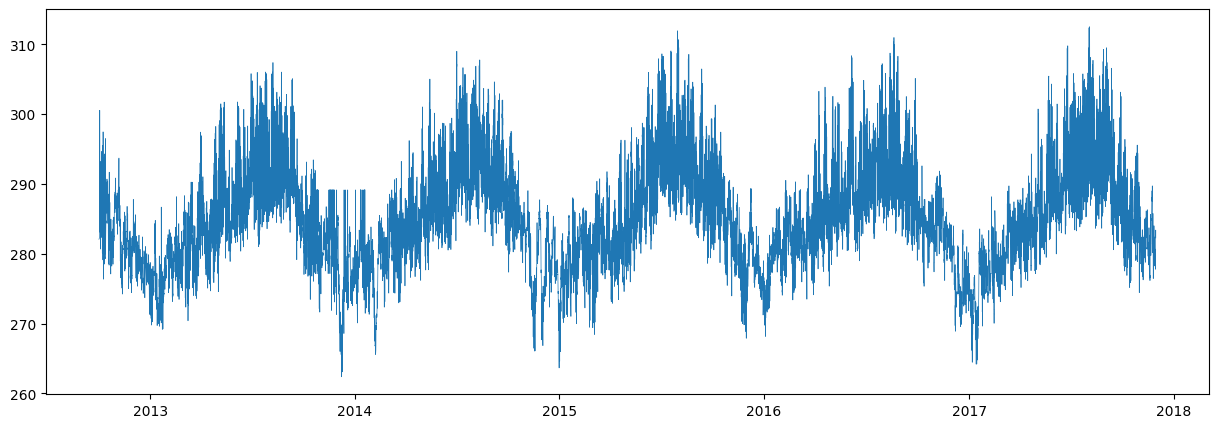

In [4]:
plt.figure(figsize=(15,5))
plt.plot(df['Portland'], lw=0.5);

Какие закономерности вы видите на графике?

**Ответ:** годичная сезоннность

Посчитайте пропуски для каждого из городов.

<AxesSubplot: >

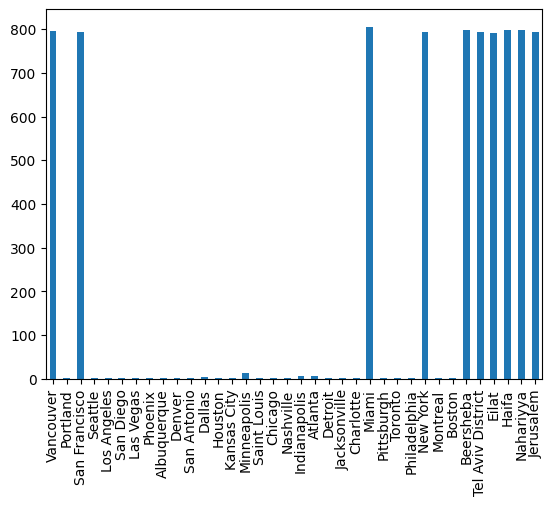

In [18]:
list_of_nans = df.isna().sum()
list_of_nans.plot.bar()

Выберите город с наименьшим количеством пропусков. Назовем этот город X.

In [21]:
list_of_nans.idxmin()

'Portland'

Если данные имеют пропуски в начале или в конце, то лучше обрезать данные. Остальные пропуски стоит заполнить предыдущим значением по дате. Для этого вам может помочь функция `pandas.DataFrame.fillna`.

In [24]:
portland_temps = df['Portland'][1:]
portland_temps 

datetime
2012-10-01 13:00:00    282.080000
2012-10-01 14:00:00    282.083252
2012-10-01 15:00:00    282.091866
2012-10-01 16:00:00    282.100481
2012-10-01 17:00:00    282.109095
                          ...    
2017-11-29 20:00:00    282.000000
2017-11-29 21:00:00    282.890000
2017-11-29 22:00:00    283.390000
2017-11-29 23:00:00    283.020000
2017-11-30 00:00:00    282.280000
Name: Portland, Length: 45252, dtype: float64

In [29]:
test_mask = portland_temps.index > portland_temps.index.max() - pd.DateOffset(years=1)

Для города X будем предсказывать температуру с помощью моделей машинного обучения.


Разбейте данные на обучение и тест. Для тестовой выборки используйте последние **365 дней** из данных (не забывайте, что в данных представлены показатели за каждый час).


In [30]:
train = portland_temps[~test_mask]
test = portland_temps[test_mask]

С форматом даты модели работать не умеют, поэтому нам необходимо описать дату признаками. Сделаем преобразование даты в признаки. 

In [31]:
def create_date_features(date):
    """Создает фичи из даты"""
    row = {}
    row["dayofweek"] = date.dayofweek 
    row["quarter"] = date.quarter 
    row["month"] = date.month 
    row["year"] = date.year 
    row["dayofyear"] = date.dayofyear 
    row["dayofmonth"] = date.day 
    row["weekofyear"] = date.weekofyear 
    return row

def create_only_date_train_features(y_series): 
    """
    Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    time_features = pd.DataFrame(
    [create_date_features(date) for date in y_series.index] )
    return time_features, y_series

In [32]:
X_train, y_train = create_only_date_train_features(train)
X_test, y_test = create_only_date_train_features(test)

In [33]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,4,10,2012,275,1,40
1,0,4,10,2012,275,1,40
2,0,4,10,2012,275,1,40
3,0,4,10,2012,275,1,40
4,0,4,10,2012,275,1,40
...,...,...,...,...,...,...,...
36487,1,4,11,2016,334,29,48
36488,1,4,11,2016,334,29,48
36489,1,4,11,2016,334,29,48
36490,1,4,11,2016,334,29,48


Постройте и обучите три модели: 
* модель линейной регрессии 
* решающего дерева
* случайного леса.

In [36]:
models = [LinearRegression(), DecisionTreeRegressor(max_depth=3), RandomForestRegressor(max_depth=3)]
model_names = ['линейная регрессия', 'решающее дерево', 'случайный лес']
metrics = {}

for model,model_name in zip(models,model_names):
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    metric ={}
    metric['MSE'] = mean_absolute_error(test_pred, y_test)
    metric['MAE']= mean_absolute_error(test_pred, y_test)
    metric['MAPE'] = mean_absolute_percentage_error(test_pred,  y_test)
    metrics[model_name] = metric

Посчитайте качество на тесте (MSE, MAE, MAPE).



In [37]:
metrics

{'линейная регрессия': {'MSE': 6.797180346394164,
  'MAE': 6.797180346394164,
  'MAPE': 0.023547249596764852},
 'решающее дерево': {'MSE': 3.970175203816492,
  'MAE': 3.970175203816492,
  'MAPE': 0.013875268744567348},
 'случайный лес': {'MSE': 3.9075348546965394,
  'MAE': 3.9075348546965394,
  'MAPE': 0.013658715807903732}}

Визуализируйте результат.

In [42]:
def plot_results(y_to_train, y_to_test, y_forecast,model_name): 
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
        - y_to_train: pd.Series
            Временной ряд, на котором обучалась модель.
        - y_to_test: pd.Series
            Временной ряд, который предсказывает модель.
        - y_forecast: array
            Предсказания модели.
        - plot_conf_int: bool
            Надо ли строить предсказательного интервал.
        - left_bound: array
            Левая граница предсказательного интервала.
        - right_bound: array
            Правая граница предсказательного интервала.
    """
    plt.figure(figsize=(15, 5))
    plt.title(f"Показатели температуры для города Х. Модель {model_name}", fontsize=15) 
    plt.plot(y_to_train, label="train")
    plt.plot(y_to_test, label="test")
    plt.plot(y_to_test.index, y_forecast, label="prediction") 
    plt.legend()
    plt.show()

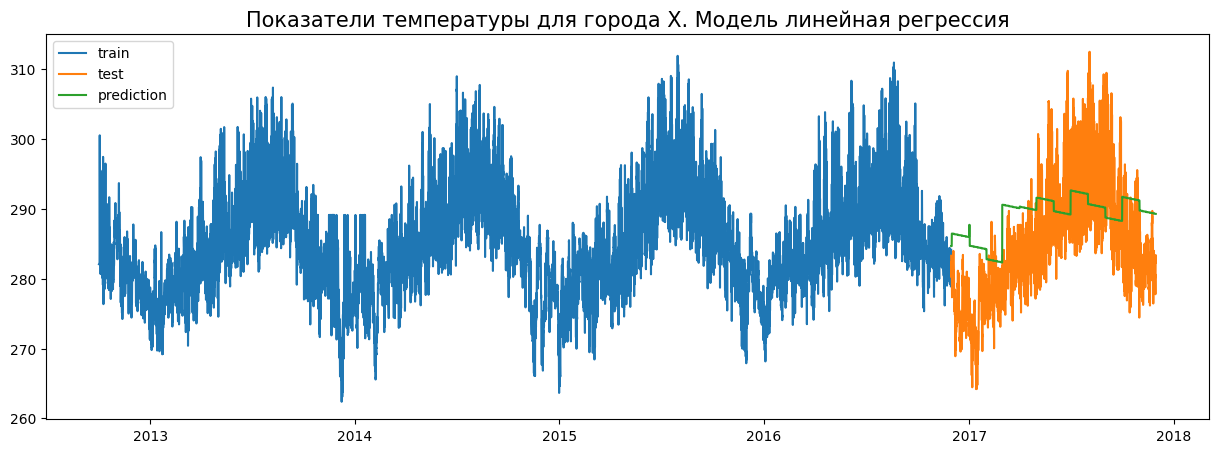

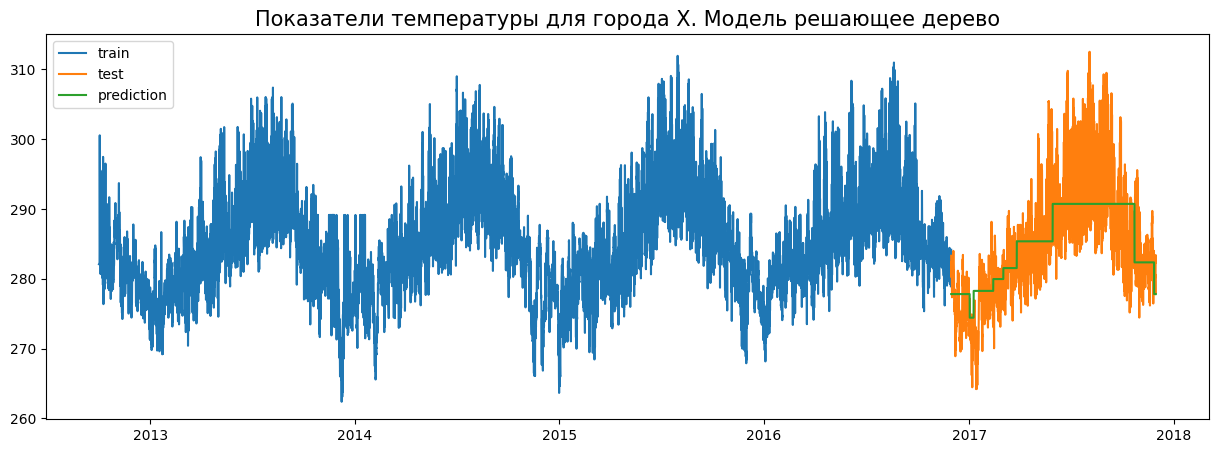

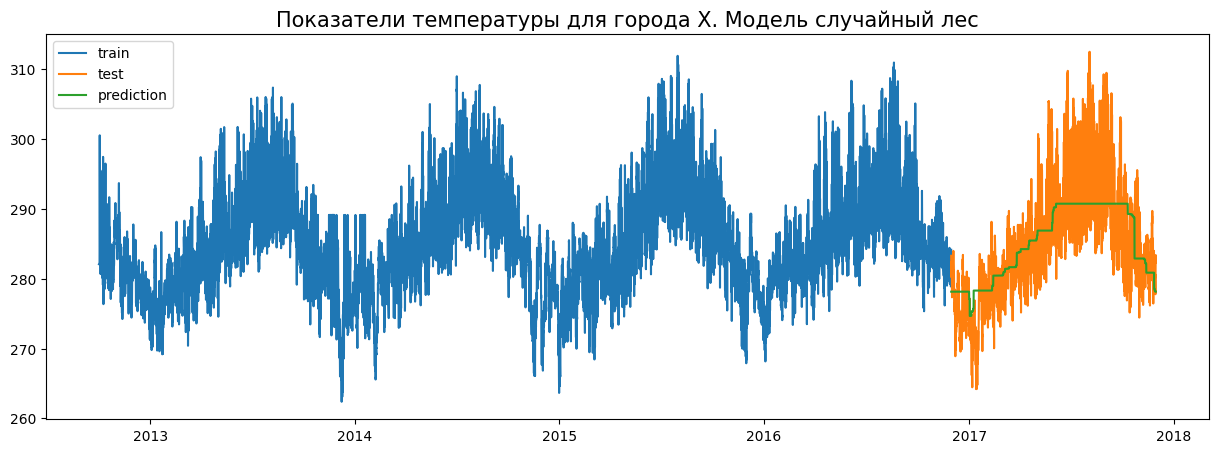

In [45]:
for model,model_name in zip(models,model_names):
    plot_results(y_train, y_test,model.predict(X_test),model_name=model_name)

Сделайте выводы.

**Вывод:**
Tree-based модели превосходят линейную регрессию в аппроксимации сезонного цикла. При ограниченной глубине деревья не стремятся к аппроксимации значений температуры по дням, находят среднемесячные значения. Умеют находить сезонные закономерности в волатильном временном ряде.
С другой стороны, в условиях возрастающего или нисходящего линейного тренда деревья теоретически будут показывать худшие результаты, поскольку не способны на экстраполяцию.  